# Simple TOPFARM Example

In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [52]:
from py_wake.examples.data.dtu10mw import DTU10MW
from py_wake.examples.hornsrev1_example import Hornsrev1Site
from py_wake import Nygaard_2022

from topfarm import TopFarmProblem, TopFarmGroup
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
#from topfarm.easy_drivers import EasyRandomSearchDriver
#from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation
from topfarm.utils import plot_list_recorder

from optiwindnet.api import WindFarmNetwork, EWRouter, HGSRouter , MILPRouter
from optiwindnet.augmentation import poisson_disc_filler

# gradient
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent


In [53]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Wind farm design parameters

Define turbine type and count:

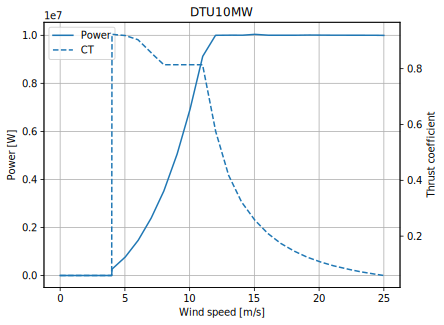

In [54]:
wind_turbines = DTU10MW()
n_wt = 20
wind_turbines.plot_power_ct();

Define the wind resource:

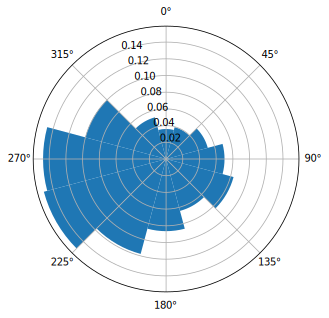

In [55]:
site = Hornsrev1Site()
site.plot_wd_distribution();

Define the area:

In [56]:
d_west_east = 4000  # [m] width
d_south_north = 2000  # [m] height
min_wt_spacing = 3.5*wind_turbines.diameter()  # [m] inter-turbine minimum distance
boundary = np.array([
    (0, 0),
    (d_west_east, 0),
    (d_west_east, d_south_north),
    (0, d_south_north)
])

Define the substation position:

In [57]:
x_ss, y_ss = (d_west_east/5, d_south_north/2)

Define the maximum step for the random search:

In [58]:
max_step = 100  # [m]

## Initial positions

In [59]:
# Generate initial random layout
x_init, y_init = poisson_disc_filler(
    n_wt,
    min_dist=min_wt_spacing,
    BorderC=boundary,
    seed=42,
    rounds=10,
).T

Define the substation position:

In [60]:
x_ss, y_ss = (d_west_east/5, d_south_north/2)

## Electrical cabling

In [61]:
wfn = WindFarmNetwork(
    turbinesC=np.column_stack((x_init, y_init)),
    substationsC=np.array([(x_ss, y_ss)]),
    #borderC=boundary,
    cables=[(2, 2000), (5, 2200)],
    buffer_dist=max_step,
    #router=HGSRouter(time_limit=0.1),
    router=MILPRouter(
         solver_name='cplex',
         # solver_name='ortools',
         time_limit=5,
         mip_gap=0.005
     ),
)

In [62]:
wfn.plot_original_vs_buffered();

No buffering is perfomred


Generate initial network

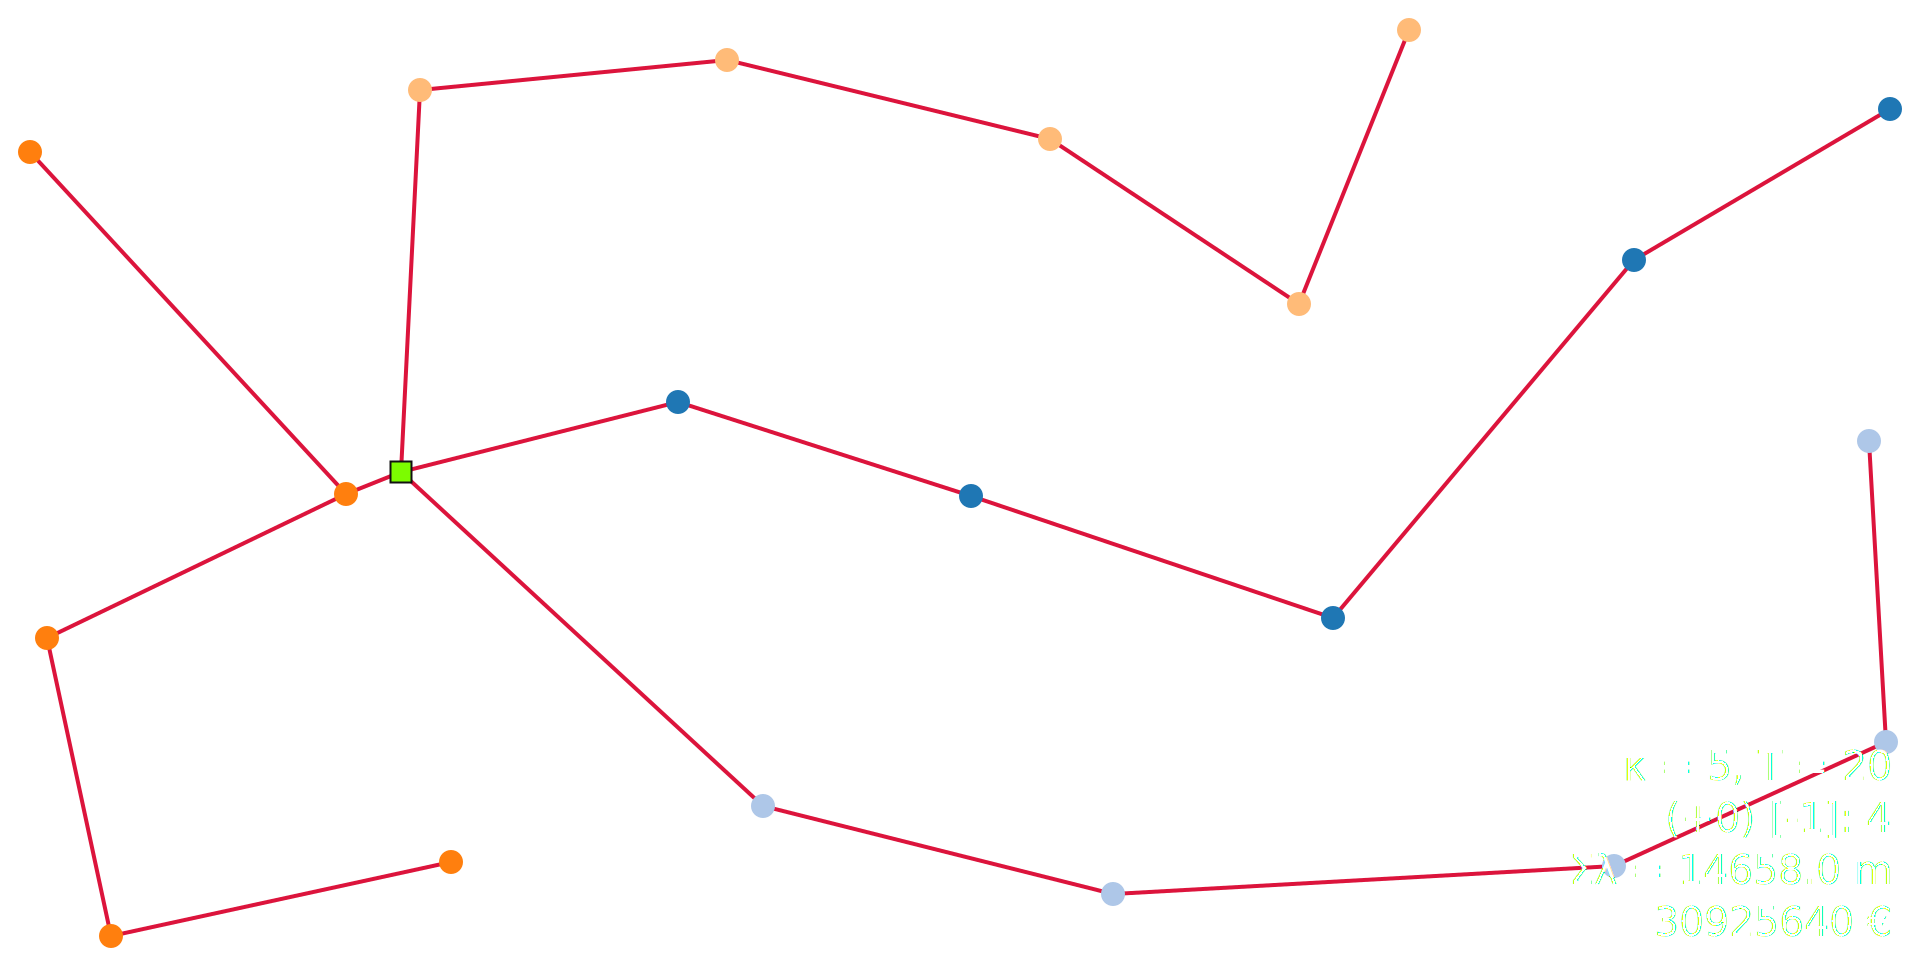

In [63]:
wfn.optimize()
wfn

## Build models

In [64]:
fixed_economic_parameters = dict(
    rated_rpm_array=np.full((n_wt,), 12.0),
    D_rotor_array=np.full((n_wt,), wind_turbines.diameter()),
    Power_rated_array=np.full((n_wt,), wind_turbines.power(20.0)*1e-6),
    hub_height_array=np.full((n_wt,), wind_turbines.hub_height()),
    water_depth_array=np.full((n_wt,), 33.0),
)

In [65]:
eco_eval = economic_evaluation(
    distance_from_shore=30,  # [km]
    energy_price=0.06,        # [€/kWh] revenue
    project_duration=25,     # [years]
)

In [66]:
# Internal Rate of Return
def calc_irr(AEP, cabling_cost, **kwargs):
    return eco_eval.calculate_irr(
        **fixed_economic_parameters,
        aep_array=np.full((n_wt,), AEP/n_wt*10**6),
        cabling_cost=cabling_cost,
    )

In [67]:
# number of wind directions to consider
n_wd = 12

aep_comp = PyWakeAEPCostModelComponent(
    windFarmModel=Nygaard_2022(
        site=site,
        windTurbines=wind_turbines,
    ),
    n_wt=n_wt,
    wd=np.linspace(0.0, 360.0, n_wd, endpoint=False),
    objective=False,
)

In [68]:
# Economy
npv_comp = CostModelComponent(
    input_keys=[
        ('AEP', 0),
        ('cabling_cost', wfn.cost())
    ],
    n_wt=n_wt,
    # cost_function=calc_npv,
    cost_function=calc_irr,
    objective=True,
    maximize=True,
    # output_keys=[('NPV', 0)],
    output_keys=[('IRR', 0)],
)

In [69]:
router_warmstart = HGSRouter(time_limit=0.1)
router = MILPRouter(solver_name='cplex', time_limit=2, mip_gap=0.005)

turbines_pos = np.column_stack((x_init, y_init))
substations_pos = np.column_stack((x_ss, y_ss))

cables = np.array([(2, 2000), (5, 2200)])

wfn =  WindFarmNetwork(
                        turbinesC=turbines_pos,
                        substationsC=substations_pos,
                        cables=cables,
                        router=router,
                        )  # , borderC=boundary

class WFNComponent(CostModelComponent):
    def __init__(self, wfn, x_init, y_init, **kwargs):


        self.wfn = wfn

        def compute(x, y, xs, ys):
            # self.wfn.optimize(
            #                   turbinesC=np.column_stack((x, y)),
            #                   substationsC=np.array([[xs, ys]], dtype=float),
            #                   router=self.router_warmstart)
            self.wfn.optimize(turbinesC=np.column_stack((x, y)),
                              substationsC=np.column_stack((xs, ys)),
                              )
            return self.wfn.cost(), {
                'network_length': self.wfn.length(),
                'terse_links': self.wfn.terse_links(),
            }

        def compute_partials(x, y, xs, ys):
            grad_wt, grad_ss = self.wfn.gradient(
                turbinesC=np.column_stack((x, y)),
                substationsC=np.column_stack((xs, ys)),
            )
            dc_dx, dc_dy = grad_wt[:, 0], grad_wt[:, 1]
            dc_dxss, dc_dyss = grad_ss[:, 0], grad_ss[:, 1]
            return [dc_dx, dc_dy, dc_dxss, dc_dyss]

        super().__init__(
            input_keys=[('x', x_init), ('y', y_init),
                        ('xs', x_ss), ('ys', y_ss)],
            n_wt=wfn.L.graph['T'],
            cost_function=compute,
            cost_gradient_function=compute_partials,
            objective=False,
            output_keys=[('cabling_cost', 0.0)],
            additional_output=[
                ('network_length', 0.0),
                ('terse_links', np.zeros((wfn.L.graph['T'],))),
            ],
            **kwargs,
        )


In [70]:
network_cost_comp = WFNComponent(
    wfn=wfn,
    x_init=x_init,
    y_init=y_init,
)

## Build Topfarm problem

In [71]:
cost_comp = TopFarmGroup([
    aep_comp,
    network_cost_comp,
    npv_comp,
])

In [72]:
tf_problem = TopFarmProblem(
    design_vars=dict(
        x=x_init,
        y=y_init,
    ),
    cost_comp=cost_comp,
    constraints=[
        XYBoundaryConstraint(boundary, 'polygon'),
        SpacingConstraint(min_wt_spacing)
    ],
    driver=EasyScipyOptimizeDriver(tol=1e-12, disp=True),
    #     EasyRandomSearchDriver(
    #     RandomizeTurbinePosition_Circle(max_step=max_step),
    #     max_iter=2000,
    #     max_time=600,
    # ),
    plot_comp=XYPlotComp(),
)

INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000454 sec).
INFO: checking system...
INFO:     system check complete (0.000042 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000287 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000075 sec).
INFO: checking missing_recorders...


INFO:     missing_recorders check complete (0.000008 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000302 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000095 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000006 sec).


INFO: checking out_of_order...
INFO:     out_of_order check complete (0.000675 sec).
INFO: checking system...
INFO:     system check complete (0.000055 sec).
INFO: checking solvers...
INFO:     solvers check complete (0.000671 sec).
INFO: checking dup_inputs...
INFO:     dup_inputs check complete (0.000148 sec).
INFO: checking missing_recorders...
INFO:     missing_recorders check complete (0.000014 sec).
INFO: checking unserializable_options...
INFO:     unserializable_options check complete (0.000480 sec).
INFO: checking comp_has_no_outputs...
INFO:     comp_has_no_outputs check complete (0.000143 sec).
INFO: checking auto_ivc_warnings...
INFO:     auto_ivc_warnings check complete (0.000012 sec).


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


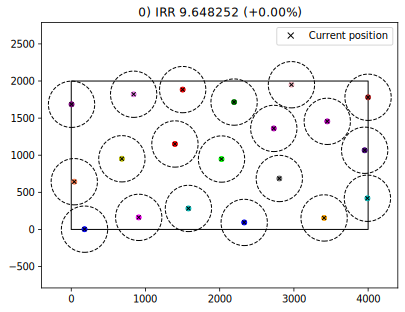

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Iteration limit reached    (Exit mode 9)
            Current function value: -10.261810194993458
            Iterations: 200
            Function evaluations: 578
            Gradient evaluations: 200
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimized in	350.469s
 

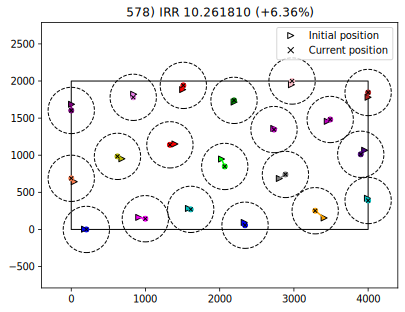

         257261758 function calls (254765562 primitive calls) in 349.105 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      579  101.197    0.175  104.727    0.181 {built-in method cplex._internal.py312_cplex2212.CPXXmipopt}
2451359/1679359   11.076    0.000   39.268    0.000 tracer.py:35(f_wrapped)
    14801    6.690    0.000   15.662    0.001 grid_interpolator.py:48(__call__)
    29602    4.997    0.000   17.956    0.001 gaussian.py:427(sigma_ijlk)
     1158    4.368    0.004    4.665    0.004 mesh.py:208(_planar_from_cdt_triangles)
   694000    3.783    0.000   12.044    0.000 core.py:56(vjp_argnums)
  1430884    3.700    0.000    4.154    0.000 component_set.py:83(<genexpr>)
   291760    3.637    0.000    5.394    0.000 standard_repn.py:260(generate_standard_repn)
  2838277    3.079    0.000   10.904    0.000 constraint.py:178(to_bounded_expression)
    43469    2.921    0.000    2.921    0.000 {method 'flush' of '_i

In [73]:
%prun cost, state, recorder = tf_problem.optimize(disp=True)

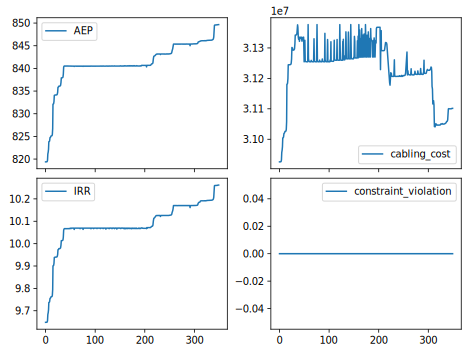

In [74]:
records_to_plot = ['AEP', 'cabling_cost', 'IRR', 'constraint_violation']
time = recorder['timestamp'] - recorder['timestamp'][0]
fig, axs = plt.subplots(math.ceil(len(records_to_plot)/2), 2, sharex=True, layout='constrained')
for ax, record_key in zip(axs.ravel(), records_to_plot):
    ax.plot(time, recorder[record_key], label=record_key)
    ax.legend()

<Axes: >

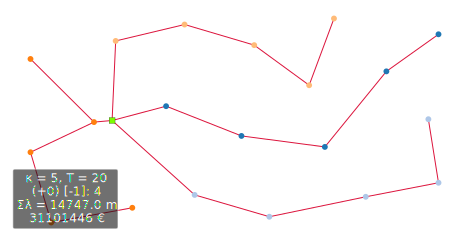

In [75]:
wfn.plot()